# Modeling

## Setup

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import time
import json
import gc
from IPython.display import clear_output

import numpy as np
import pandas as pd

import numpy as np
import pandas as pd
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.python.distribute.tpu_strategy import def_function

import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import joblib

import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table

In [3]:
# Define a custom color palette with a single black color
black_palette = sns.color_palette(['black'])

# Set the color palette to the custom palette
sns.set_palette(black_palette)

# Set the Style to Darkgrid
sns.set_style("darkgrid")

## Create Function that Executes Machine Learning Pipeline
The following function loads data from Google BigQuery, apply's the necessary transformations to that data, trains the models (except for the Black Scholes Model that doesn't require training), makes predictions, displays the results, and creates directories to save the trained models and the testing results.

In [4]:
from tensorflow.python.distribute.tpu_strategy import def_function
def execute(input_model, model_type, file_name):
  # Collect Garbage
  gc.collect()
  # Create Functions that creates directories
  def create_directory(dir_name):
      if not os.path.exists(dir_name):
          os.makedirs(dir_name)
  # Create directories to store the models and results
  directories = ['models', 'test_results']
  for dir_name in directories:
      create_directory(dir_name)
  # Create Function that loads data from BigQuery
  def load_data(model_type):
    # Initalize Big Query Client and Authenticate User
    project = 'acms80695-384817'
    location = 'US'
    client = bigquery.Client(project=project, location=location)
    data_table.enable_dataframe_formatter()
    auth.authenticate_user()
    # Load data for the Black Scholes Model
    if model_type == 'Black_Scholes':
      query = """SELECT * FROM `acms80695-384817.Options_Dataset.X_train_bs`"""
      X_train = client.query(query).to_dataframe()
      X_train.set_index('index', inplace=True)
      X_train.sort_index(inplace=True)
      X_train = X_train.astype(np.float16)
      query = """SELECT * FROM `acms80695-384817.Options_Dataset.X_val_bs`"""
      X_val = client.query(query).to_dataframe()
      X_val.set_index('index', inplace=True)
      X_val.sort_index(inplace=True)
      X_val = X_val.astype(np.float16)
      query = """SELECT * FROM `acms80695-384817.Options_Dataset.X_test_bs`"""
      X_test = client.query(query).to_dataframe()
      X_test.set_index('index', inplace=True)
      X_test.sort_index(inplace=True)
      X_test = X_test.astype(np.float16)
      query = """SELECT * FROM `acms80695-384817.Options_Dataset.y_train_bs`"""
      y_train = client.query(query).to_dataframe()
      y_train.set_index('index', inplace=True)
      y_train.sort_index(inplace=True)
      y_train = y_train.astype(np.float16)
      query = """SELECT * FROM `acms80695-384817.Options_Dataset.y_val_bs`"""
      y_val = client.query(query).to_dataframe()
      y_val.set_index('index', inplace=True)
      y_val.sort_index(inplace=True)
      y_val = y_val.astype(np.float16)
      query = """SELECT * FROM `acms80695-384817.Options_Dataset.y_test_bs`"""
      y_test = client.query(query).to_dataframe()
      y_test.set_index('index', inplace=True)
      y_test.sort_index(inplace=True)
      y_test = y_test.astype(np.float16)
      return X_train, X_val, X_test, y_train, y_val, y_test
    # Load data for either the TensorFlow models or the XGBoost Models
    elif model_type == 'TensorFlow' or model_type == 'XGBoost':
      query = """SELECT * FROM `acms80695-384817.Options_Dataset.X_train_tf_xgb`"""
      X_train = client.query(query).to_dataframe()
      X_train.set_index('index', inplace=True)
      X_train.sort_index(inplace=True)
      X_train = X_train.astype(np.float16)
      query = """SELECT * FROM `acms80695-384817.Options_Dataset.X_val_tf_xgb`"""
      X_val = client.query(query).to_dataframe()
      X_val.set_index('index', inplace=True)
      X_val.sort_index(inplace=True)
      X_val = X_val.astype(np.float16)
      query = """SELECT * FROM `acms80695-384817.Options_Dataset.X_test_tf_xgb`"""
      X_test = client.query(query).to_dataframe()
      X_test.set_index('index', inplace=True)
      X_test.sort_index(inplace=True)
      X_test = X_test.astype(np.float16)
      query = """SELECT * FROM `acms80695-384817.Options_Dataset.y_train_tf_xgb`"""
      y_train = client.query(query).to_dataframe()
      y_train.set_index('index', inplace=True)
      y_train.sort_index(inplace=True)
      y_train = y_train.astype(np.float16)
      query = """SELECT * FROM `acms80695-384817.Options_Dataset.y_val_tf_xgb`"""
      y_val = client.query(query).to_dataframe()
      y_val.set_index('index', inplace=True)
      y_val.sort_index(inplace=True)
      y_val = y_val.astype(np.float16)
      query = """SELECT * FROM `acms80695-384817.Options_Dataset.y_test_tf_xgb`"""
      y_test = client.query(query).to_dataframe()
      y_test.set_index('index', inplace=True)
      y_test.sort_index(inplace=True)
      y_test = y_test.astype(np.float16)
      return X_train, X_val, X_test, y_train, y_val, y_test
    # Print Error Message for any other Model Type
    else:
      print("Error: Invalid Model Type.")
  # Create Function to display results
  def display_results(test_results, training_time):
    clear_output()
    # Print training time
    if model_type == 'Black Scholes':
      print("Model does not require training.")
    else:
      print("Elapsed time: {:.2f} seconds".format(training_time))
    print()
    display(test_results.head())
    display(test_results.tail())
    print('Mean Absolute Error:', round(test_results['Absolute Error'].mean(), 5))
    plt.figure()
    sns.scatterplot(x='True', y='Absolute Error', data=test_results)
    plt.xscale('log')
    plt.yscale('log')
    plt.show()
    print()
    print('Mean Absolute Percentage Error:', round(test_results['Absolute Percentage Error'].mean(), 5), '%')
    plt.figure()
    sns.scatterplot(x='True', y='Absolute Percentage Error', data=test_results)
    plt.xscale('log')
    plt.yscale('log')
    plt.show()
  # Train and Run the Black Scholes Model
  if model_type == 'Black_Scholes':
    # Load Data
    X_train, X_val, X_test, y_train, y_val, y_test = load_data("Black_Scholes")
    # Make Predictions
    test_results = pd.DataFrame()
    test_results['Predicted'] = X_test.apply(input_model, axis=1)
    test_results['True'] = y_test['midpoint']
    test_results['Difference'] = test_results['Predicted'] - test_results['True']
    test_results['Absolute Error'] = abs(test_results['Difference'])
    test_results['Absolute Percentage Error'] = abs(test_results['Difference'] / test_results['True']) * 100
    test_results = test_results.drop(columns=['Difference'])
    test_results = test_results.sort_values(by='True', ascending=False)
    test_results.to_csv('test_results/' + file_name +'.csv', index=False)
    training_time = np.nan
    # Display Results
    display_results(test_results, training_time)
    # Free Up RAM Space
    del X_train, X_val, X_test, y_train, y_val, y_test
    gc.collect()
  # Train and Run the TensorFlow Model
  elif model_type == 'TensorFlow':
    # Check if a TPU is available
    if 'COLAB_TPU_ADDR' in os.environ:
        tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
        print('TPU address is', tpu_address)
    else:
        print('No TPU available')
    # Set TPU Strategy
    tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
    tf.config.experimental_connect_to_cluster(tpu_resolver)
    tf.tpu.experimental.initialize_tpu_system(tpu_resolver)
    tpu_strategy = tf.distribute.TPUStrategy(tpu_resolver)
    print("TPU initialized")
    # Check the number of TPUs available
    devices = tf.config.list_logical_devices('TPU')
    print("Number of TPUs available:", len(devices))
    # Load Data
    X_train, X_val, X_test, y_train, y_val, y_test = load_data("TensorFlow")
    # Train Model
    start_time = time.time()
    model = input_model(X_train, X_val, X_test, y_train, y_val, y_test,
                                tpu_strategy)
    end_time = time.time()
    training_time = end_time - start_time
    model.save('models/' + file_name + '.h5')
    # Make Predictions
    best_model = load_model('models/' + file_name + '.h5')
    predictions = best_model.predict(X_test)
    test_results = pd.DataFrame({'Predicted': predictions[:, 0], 'True': y_test.squeeze()})
    test_results['Difference'] = test_results['Predicted'] - test_results['True']
    test_results['Absolute Error'] = abs(test_results['Difference'])
    test_results['Absolute Percentage Error'] = abs(test_results['Difference'] / test_results['True']) * 100
    test_results = test_results.drop(columns=['Difference'])
    test_results = test_results.sort_values(by='True', ascending=False)
    test_results.to_csv('test_results/' + file_name + '.csv', index=False)
    # Display Results
    display_results(test_results, training_time)
    # Free Up RAM Space
    del X_train, X_val, X_test, y_train, y_val, y_test
    gc.collect()
  # Train and Run the XGBoost Model
  elif model_type == 'XGBoost':
    # Check if a GPU is available
    if tf.test.gpu_device_name():
        print('GPU available')
    else:
        print('No GPU available')
    # Load Data
    X_train, X_val, X_test, y_train, y_val, y_test = load_data("XGBoost")
    # Train Model
    start_time = time.time()
    model = input_model(X_train, X_val, X_test, y_train, y_val, y_test)
    end_time = time.time()
    training_time = end_time - start_time
    # Save the model
    joblib.dump(model, 'models/' + file_name + '.joblib')
    # Make Predictions
    best_model = joblib.load('models/' + file_name + '.joblib')
    dtest = xgb.DMatrix(X_test)
    predictions = best_model.predict(dtest)
    test_results = pd.DataFrame({'Predicted': predictions, 'True': y_test.squeeze()})
    test_results['Difference'] = test_results['Predicted'] - test_results['True']
    test_results['Absolute Error'] = abs(test_results['Difference'])
    test_results['Absolute Percentage Error'] = abs(test_results['Difference'] / test_results['True']) * 100
    test_results = test_results.drop(columns=['Difference'])
    test_results = test_results.sort_values(by='True', ascending=False)
    test_results.to_csv('test_results/' + file_name + '.csv', index=False)
    # Display Results
    display_results(test_results, training_time)
    # Free Up RAM Space
    del X_train, X_val, X_test, y_train, y_val, y_test
    gc.collect()
  # For this model only, only the predictions will be loaded from BigQuery
  # since the model has already been trained on BigQuery.
  elif model_type == 'AutoML':
    # Initalize Big Query Client and Authenticate User
    project = 'acms80695-384817'
    location = 'US'
    client = bigquery.Client(project=project, location=location)
    data_table.enable_dataframe_formatter()
    auth.authenticate_user()
    # Load Data
    query = """SELECT index, midpoint FROM `acms80695-384817.Options_Dataset.y_test_tf_xgb`"""
    y_test = client.query(query).to_dataframe()
    y_test.set_index('index', inplace=True)
    y_test.sort_index(inplace=True)
    y_test = y_test.astype(float)
    preds = pd.read_csv("/content/AutoML_Predictions.csv")
    df = pd.merge(y_test, preds, on='index', how='inner')
    # Calculate Test Results
    test_results = pd.DataFrame({'Predicted': df['predicted_midpoint'], 'True': df['midpoint']})
    test_results['Difference'] = test_results['Predicted'] - test_results['True']
    test_results['Absolute Error'] = abs(test_results['Difference'])
    test_results['Absolute Percentage Error'] = abs(test_results['Difference'] / test_results['True']) * 100
    test_results = test_results.drop(columns=['Difference'])
    test_results = test_results.sort_values(by='True', ascending=False)
    test_results.to_csv('test_results/' + file_name + '.csv', index=False)
    training_time = 174420
    # Display Results
    display_results(test_results, training_time)
    # Free Up RAM Space
    del df
    gc.collect()
  # Print Error Message for any other Model Type
  else:
    print("Error: Invalid Model Type.")

## Model 1: Black Scholes Model

In [ ]:
def black_scholes(row):
    # Extract input values from the row
    S = row['under_price']
    K = row['strike_price']
    T = row['time']
    r = row['zero_coupon']/100
    q = row['div_yield']/100
    sigma = row['impl_volatility']/100
    opt_type = row['opt_type']

    # Compute the Black-Scholes option price here
    d1 = (np.log(S/K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if opt_type == 1:
        option_price = S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif opt_type == 0:
        option_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)
    else:
        raise ValueError("Option type must be 'call' or 'put'")

    return option_price

Elapsed time: nan seconds



Predicted    True  Absolute Error  Absolute Percentage Error
index                                                                   
10653387  2197.519493  2242.0       44.480507                   1.983966
10658732  1899.525961  1981.0       81.474039                   4.112773
10658944  1873.372518  1964.0       90.627482                   4.614434
10658841  1840.258737  1881.0       40.741263                   2.165936
10658553  1619.702505  1708.0       88.297495                   5.169643

Predicted      True  Absolute Error  Absolute Percentage Error
index                                                                   
10682218        0.0  0.014999        0.014999                      100.0
10649804        0.0  0.014999        0.014999                      100.0
10749760        0.0  0.014999        0.014999                      100.0
10709110        0.0  0.014999        0.014999                      100.0
10737388        0.0  0.014999        0.014999                      100.0

Mean Absolute Error: 8.00818


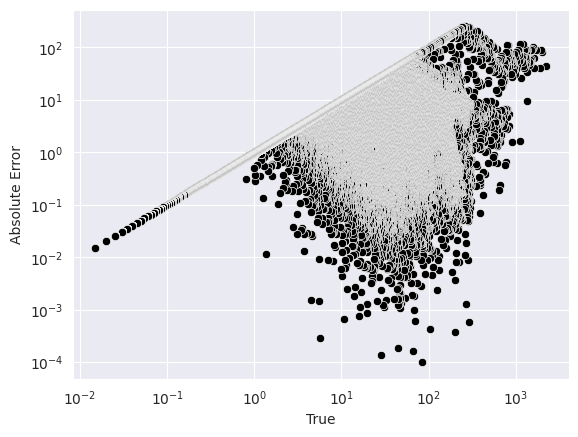


Mean Absolute Percentage Error: 63.87519 %


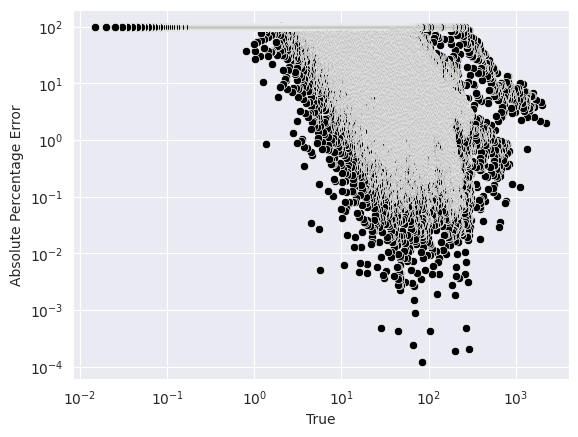

In [ ]:
execute(black_scholes, "Black_Scholes", "Black_Scholes")

## Switch to TPU Runtime
Please switch to a TPU Runtime when training the TensorFlow models. The TensorFlow models in this notebook were trained on High Ram TPU Runtimes in Google Colab, and training was distributed across eight devices.

## Model 2: 3 Layer Feed Forward Neural Network

In [ ]:
def three_layer_FFNN(X_train, X_val, X_test, y_train, y_val, y_test,
                     tpu_strategy):
  # Create model
  model = Sequential([
      Dense(256, input_dim=X_train.shape[1], activation='relu'),
      Dense(128, activation='relu'),
      Dense(1, activation='linear')
  ])
  # Define the optimizer with a relatively large learning rate
  optimizer = Adam(learning_rate=0.01)
  # Define the learning rate scheduler
  lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=30,
                                   min_lr=1e-6)
  model.compile(optimizer=optimizer, loss='mae', metrics=['mape'])
  # Define the early stopping callback
  early_stopping = EarlyStopping(monitor='val_loss', patience=150, verbose=1)
  # Train the model
  history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                      epochs=10000, batch_size=4096 * tpu_strategy.num_replicas_in_sync,
                      callbacks=[early_stopping, lr_scheduler])
  test_loss, test_mape = model.evaluate(X_test, y_test)
  print(f'Test Loss: {test_loss:.3f}, Test MAPE: {test_mape:.3f}')

  return model

Elapsed time: 3066.64 seconds



Predicted    True  Absolute Error  Absolute Percentage Error
index                                                                   
10653387  1783.717407  2242.0      458.282593                  20.440792
10658732  1622.261719  1981.0      358.738281                  18.108950
10658944  1607.457886  1964.0      356.542114                  18.153875
10658841  1719.676270  1881.0      161.323730                   8.576488
10658553  1473.068237  1708.0      234.931763                  13.754786

Predicted      True  Absolute Error  Absolute Percentage Error
index                                                                   
10682218   1.185740  0.014999        1.170741                7805.254883
10649804  -3.052087  0.014999        3.067087               20448.078125
10749760   2.200259  0.014999        2.185259               14568.988281
10709110   0.091311  0.014999        0.076312                 508.764587
10737388   1.513232  0.014999        1.498232                9988.622070

Mean Absolute Error: 8.80748


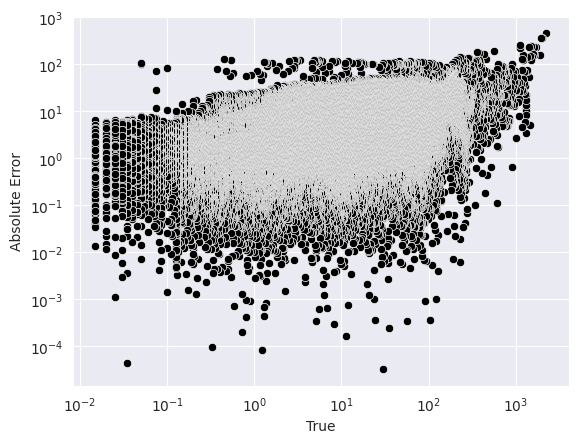


Mean Absolute Percentage Error: 323.76706 %


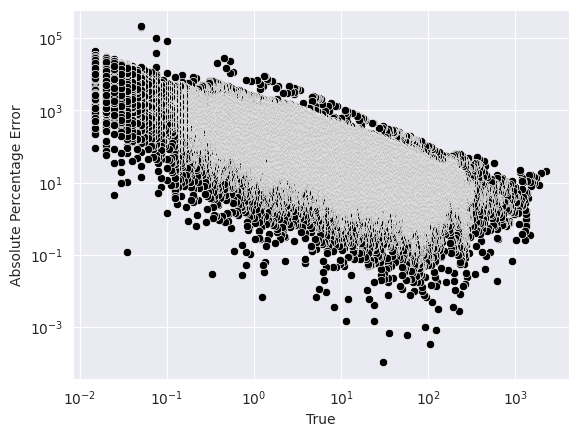

In [ ]:
execute(three_layer_FFNN, "TensorFlow", "3_Layer_FFNN")

## Model 3: 5 Layer Feed Forward Neural Network

In [ ]:
def five_layer_FFNN(X_train, X_val, X_test, y_train, y_val, y_test,
                     tpu_strategy):
  # Create model
  model = Sequential([
      Dense(256, input_dim=X_train.shape[1], activation='relu'),
      Dense(128, activation='relu'),
      Dense(64, activation='relu'),
      Dense(32, activation='relu'),
      Dense(1, activation='linear')
  ])
  # Define the optimizer with a relatively large learning rate
  optimizer = Adam(learning_rate=0.01)
  # Define the learning rate scheduler
  lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=30,
                                   min_lr=1e-6)
  model.compile(optimizer=optimizer, loss='mae', metrics=['mape'])
  # Define the early stopping callback
  early_stopping = EarlyStopping(monitor='val_loss', patience=150, verbose=1)
  # Train the model
  history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                      epochs=10000, batch_size=4096 * tpu_strategy.num_replicas_in_sync,
                      callbacks=[early_stopping, lr_scheduler])
  test_loss, test_mape = model.evaluate(X_test, y_test)
  print(f'Test Loss: {test_loss:.3f}, Test MAPE: {test_mape:.3f}')

  return model

Elapsed time: 3288.86 seconds



Predicted    True  Absolute Error  Absolute Percentage Error
index                                                                   
10653387  2160.377686  2242.0       81.622314                   3.640603
10658732  1997.306152  1981.0       16.306152                   0.823127
10658944  1992.530884  1964.0       28.530884                   1.452693
10658841  1921.485474  1881.0       40.485474                   2.152338
10658553  1696.607666  1708.0       11.392334                   0.666998

Predicted      True  Absolute Error  Absolute Percentage Error
index                                                                   
10682218  -1.129593  0.014999        1.144593                7630.928711
10649804   0.646919  0.014999        0.631919                4212.967285
10749760  -1.481316  0.014999        1.496315                9975.841797
10709110   0.263107  0.014999        0.248107                1654.116821
10737388   1.538932  0.014999        1.523933               10159.965820

Mean Absolute Error: 4.63739


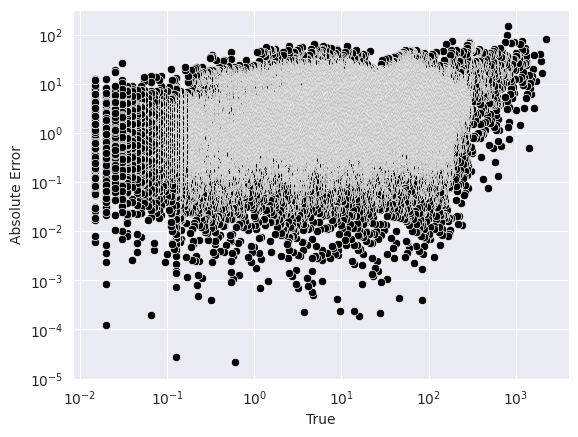


Mean Absolute Percentage Error: 243.90324 %


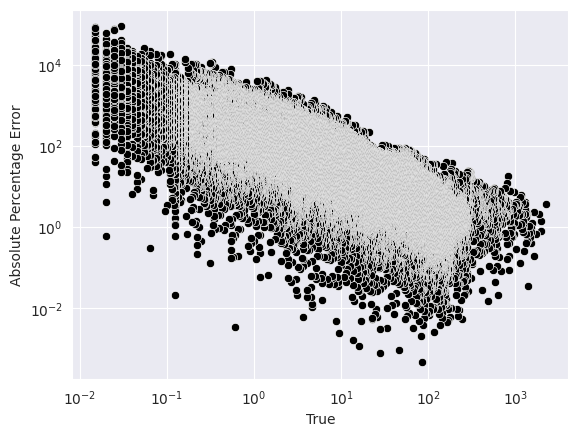

In [ ]:
execute(five_layer_FFNN, "TensorFlow", "5_Layer_FFNN")

## Switch to GPU Runtime
Please switch to a GPU Runtime when training the XGBoost models. The XGBoost models in this notebook were trained on High Ram GPU Runtimes in Google Colab.

## Model 4: XGBoost with Max Depth of 5

In [ ]:
def xgb_max_depth_5(X_train, X_val, X_test, y_train, y_val, y_test):
  # Create DMatrix
  dtrain = xgb.DMatrix(X_train, label=y_train)
  dval = xgb.DMatrix(X_val, label=y_val)
  dtest = xgb.DMatrix(X_test, label=y_test)

  # Create a function for the decayed learning rate.
  def eta_decay(iteration):
      max_iter = 100000
      x = iteration + 1
      eta_base = 0.5
      eta_min = 0.2
      eta_decay = eta_min + (eta_base - eta_min) * np.exp(-(x/8)**2 / max_iter)
      return eta_decay
  # Define Parameters
  max_iter = 40000
  eta_decay = np.array([eta_decay(iteration) for iteration in range(max_iter)])
  PARAMS = {
      'booster': 'gbtree',
      'eval_metric': 'mae',
      'max_depth': 5,  # set maximum depth of the trees to 5
      'tree_method': 'gpu_hist'
  }
  evals_result = {'train': dtrain, 'validation': dval}
  # Train Model
  progress1 = dict()
  model = xgb.train(
      maximize=True,
      params=PARAMS,
      dtrain=dtrain,
      num_boost_round=max_iter,
      early_stopping_rounds=max_iter,
      evals=[(dtrain, 'train'),(dtest, 'test')],
      evals_result=progress1,
      verbose_eval=1,
      callbacks=[xgb.callback.LearningRateScheduler(lambda iteration: eta_decay[iteration])],
  )
  # Make Predictions
  y_pred = model.predict(dtest)
  # Compute and print the MAE
  mae = mean_absolute_error(y_test, y_pred)
  print(f"Mean Absolute Error: {mae}")
  # Use the model for prediction on the test set
  y_pred_test = model.predict(dtest)
  # Compute and print the test set MAE
  mae_test = mean_absolute_error(y_test, y_pred_test)
  print(f"Test Mean Absolute Error: {mae_test}")

  return model

Elapsed time: 971.93 seconds



Predicted    True  Absolute Error  Absolute Percentage Error
index                                                                   
10653387  2243.789307  2242.0        1.789307                   0.079809
10658732  1978.739014  1981.0        2.260986                   0.114134
10658944  1965.406494  1964.0        1.406494                   0.071614
10658841  1876.728760  1881.0        4.271240                   0.227073
10658553  1702.558716  1708.0        5.441284                   0.318576

Predicted      True  Absolute Error  Absolute Percentage Error
index                                                                   
10682218   0.833674  0.014999        0.818674                5458.050781
10649804   3.753765  0.014999        3.738766               24926.119141
10749760  -0.244494  0.014999        0.259494                1730.029541
10709110   1.803085  0.014999        1.788086               11921.056641
10737388   1.678389  0.014999        1.663390               11089.716797

Mean Absolute Error: 1.63617


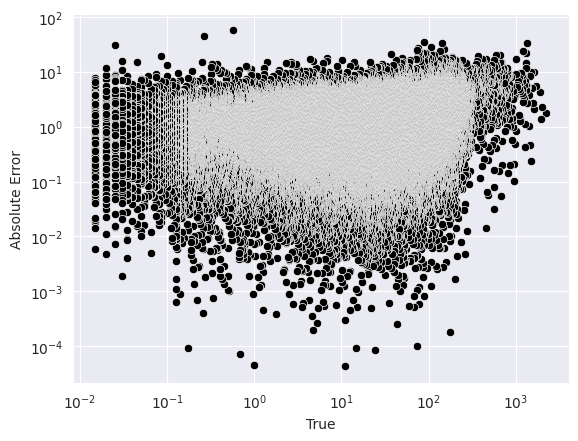


Mean Absolute Percentage Error: 187.02315 %


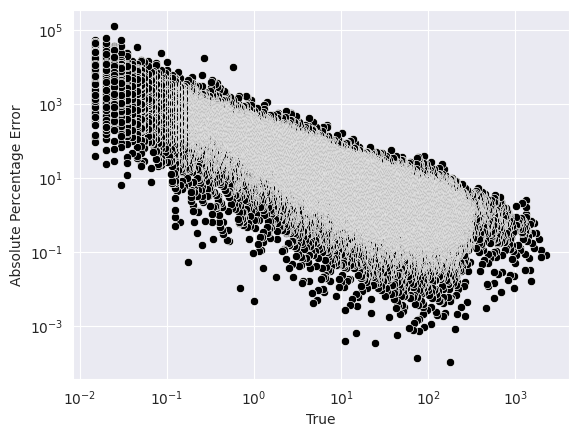

In [ ]:
execute(xgb_max_depth_5, "XGBoost", "XGBoost_Max_Depth_5")

## Model 5: XGBoost with Max Depth of 10

In [ ]:
def xgb_max_depth_10(X_train, X_val, X_test, y_train, y_val, y_test):
  # Create DMatrix
  dtrain = xgb.DMatrix(X_train, label=y_train)
  dval = xgb.DMatrix(X_val, label=y_val)
  dtest = xgb.DMatrix(X_test, label=y_test)

  # Create a function for the decayed learning rate.
  def eta_decay(iteration):
      max_iter = 100000
      x = iteration + 1
      eta_base = 0.5
      eta_min = 0.2
      eta_decay = eta_min + (eta_base - eta_min) * np.exp(-(x/8)**2 / max_iter)
      return eta_decay
  # Define Parameters
  max_iter = 40000
  eta_decay = np.array([eta_decay(iteration) for iteration in range(max_iter)])
  PARAMS = {
      'booster': 'gbtree',
      'eval_metric': 'mae',
      'max_depth': 10,  # set maximum depth of the trees to 5
      'tree_method': 'gpu_hist'
  }
  evals_result = {'train': dtrain, 'validation': dval}
  # Train Model
  progress1 = dict()
  model = xgb.train(
      maximize=True,
      params=PARAMS,
      dtrain=dtrain,
      num_boost_round=max_iter,
      early_stopping_rounds=max_iter,
      evals=[(dtrain, 'train'),(dtest, 'test')],
      evals_result=progress1,
      verbose_eval=1,
      callbacks=[xgb.callback.LearningRateScheduler(lambda iteration: eta_decay[iteration])],
  )
  # Make Predictions
  y_pred = model.predict(dtest)
  # Compute and print the MAE
  mae = mean_absolute_error(y_test, y_pred)
  print(f"Mean Absolute Error: {mae}")
  # Use the model for prediction on the test set
  y_pred_test = model.predict(dtest)
  # Compute and print the test set MAE
  mae_test = mean_absolute_error(y_test, y_pred_test)
  print(f"Test Mean Absolute Error: {mae_test}")

  return model

Elapsed time: 1917.90 seconds



Predicted    True  Absolute Error  Absolute Percentage Error
index                                                                   
10653387  2246.381348  2242.0        4.381348                   0.195421
10658732  1980.704346  1981.0        0.295654                   0.014924
10658944  1961.836426  1964.0        2.163574                   0.110162
10658841  1878.614624  1881.0        2.385376                   0.126814
10658553  1704.537109  1708.0        3.462891                   0.202745

Predicted      True  Absolute Error  Absolute Percentage Error
index                                                                   
10682218   0.084594  0.014999        0.069595                 463.982544
10649804   0.014085  0.014999        0.000914                   6.094239
10749760  -0.206386  0.014999        0.221385                1475.960693
10709110  -0.044853  0.014999        0.059853                 399.034607
10737388  -0.453913  0.014999        0.468913                3126.212158

Mean Absolute Error: 0.8093


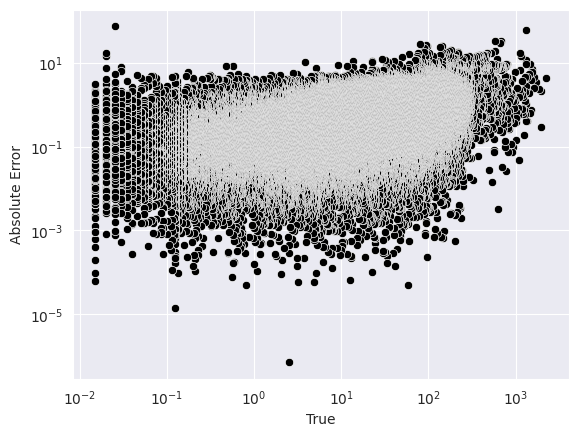


Mean Absolute Percentage Error: 42.22876 %


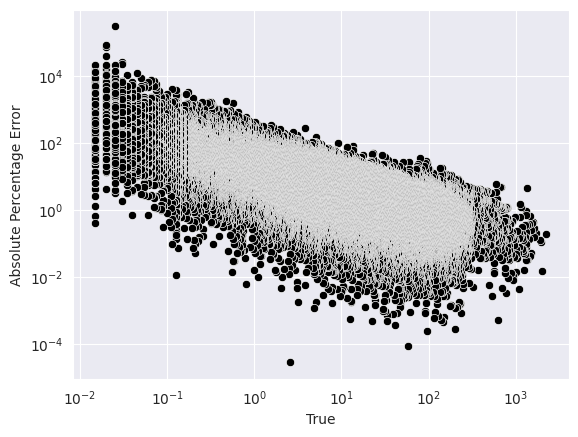

In [ ]:
execute(xgb_max_depth_10, "XGBoost", "XGBoost_Max_Depth_10")

## Model 6: Google AutoML Regressor

![Version Details](https://github.com/juan-esteban-berger/Options_Pricing_AutoML_TensorFlow_XGBoost/raw/main/images/version_details.jpg)

![Feature Importance](https://github.com/juan-esteban-berger/Options_Pricing_AutoML_TensorFlow_XGBoost/raw/main/images/Feature_Importance.jpg)

Elapsed time: 174420.00 seconds



Predicted     True  Absolute Error  Absolute Percentage Error
10010  2253.642090  2241.10       12.542090                   0.559640
15355  1965.489014  1981.15       15.660986                   0.790500
15567  1968.788086  1963.85        4.938086                   0.251449
15464  1876.731201  1880.55        3.818799                   0.203068
15176  1699.864990  1708.20        8.335010                   0.487941

Predicted   True  Absolute Error  Absolute Percentage Error
53312  -0.027823  0.015        0.042823                 285.485147
23674   0.180017  0.015        0.165017                1100.112104
40054   0.211073  0.015        0.196073                1307.154401
87389  -0.110325  0.015        0.125325                 835.501448
61086   0.162603  0.015        0.147603                 984.019343

Mean Absolute Error: 1.02484


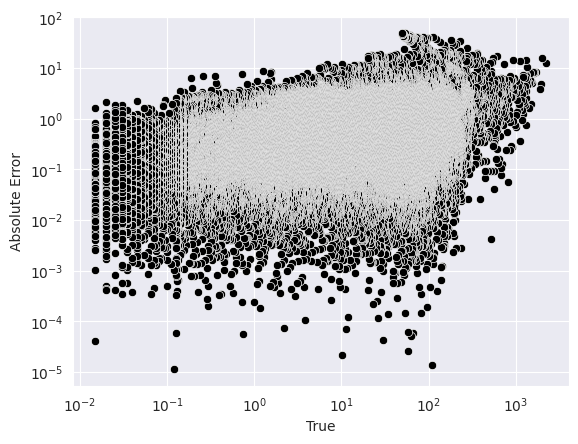


Mean Absolute Percentage Error: 42.73414 %


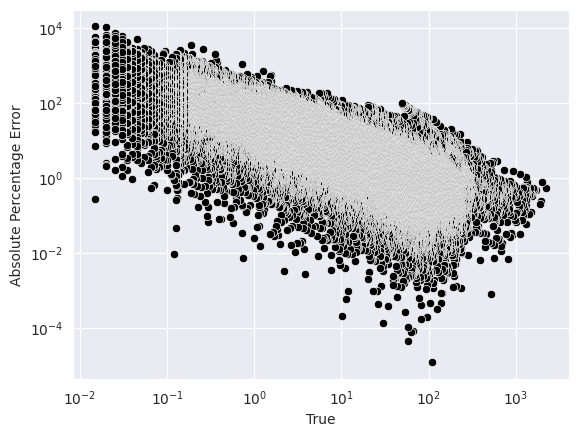

In [6]:
execute(None, "AutoML", "AutoML_Regressor")

## Results

In [7]:
# Initalize Big Query Client and Authenticate User
project = 'acms80695-384817'
location = 'US'
client = bigquery.Client(project=project, location=location)
data_table.enable_dataframe_formatter()
auth.authenticate_user()
# Load Data from BigQuery
query = """SELECT * FROM `acms80695-384817.Options_Dataset.Data_Splits`"""
df = client.query(query).to_dataframe()
df.set_index('index', inplace=True)
df.sort_index(inplace=True)

In [9]:
# Import Results Data
Black_Scholes = pd.read_csv('test_results/Black_Scholes.csv')
layer3_FFNN = pd.read_csv('test_results/3_Layer_FFNN.csv')
layer5_FFNN = pd.read_csv('test_results/5_Layer_FFNN.csv')
XGBoost_5 = pd.read_csv('test_results/XGBoost_Max_Depth_5.csv')
XGBoost_10 = pd.read_csv('test_results/XGBoost_Max_Depth_10.csv')
AutoML_Regressor = pd.read_csv('test_results/AutoML_Regressor.csv')

In [11]:
# Process Results Data
df_test = df[df['DATA_SPLIT_COL'] == 'TEST']
df_test = df_test.drop(['DATA_SPLIT_COL', 'date'], axis=1)
df_test = df_test.reset_index(drop = True)
df_test = df_test.astype(float)

In [12]:
# Rename `strike_price` to `Strike Price`
df_test.rename(columns={'strike_price': 'Strike Price'}, inplace=True)
# Rename 'under_lag0' to 'underlying_price'
df_test.rename(columns={'under_price': 'Underlying Price'}, inplace=True)
# Rename 'zero_coupon' to 'Zero Coupon Rate'
df_test.rename(columns={'zero_coupon': 'Zero Coupon Rate'}, inplace=True)
# Rename 'div_yield' to 'Dividend Yield'
df_test.rename(columns={'div_yield': 'Dividend Yield'}, inplace=True)
# Rename 'midpoint' to 'Bid and Ask Midpoint Price'
df_test.rename(columns={'midpoint': 'Bid-Ask Midpoint Price'}, inplace=True)
# Rename 'opt_type' to Option Type'
df_test.rename(columns={'opt_type': 'Option Type'}, inplace=True)
# Rename 'time' to 'Time to Maturity (years)'
df_test.rename(columns={'time': 'Time to Maturity (years)'}, inplace=True)

In [13]:
# Filter all the columns that start with 'under_lag'
price_columns = [col for col in df_test.columns if col.startswith('under_lag')]
price_test = df_test[price_columns].astype(float)
# Make a Column with Each Rows Standard Deviation
df_test['Historical Volatility'] = price_test.std(axis=1)

In [14]:
# Revert 'Option Type' to 'Call' or 'Put'
df_test['Option Type'] = df_test['Option Type'].apply(lambda x: 'Call' if x == 1 else 'Put')
# Sort df_filt by 'Option Price' in descending order
df_test = df_test.sort_values(by='Bid-Ask Midpoint Price', ascending=False)

In [15]:
# Append the 'Absolute Error' columns from the results dataframes to df_test
df_test['Black-Scholes Absolute Error'] = Black_Scholes['Absolute Error']
df_test['3 Layer FFNN Absolute Error'] = layer3_FFNN['Absolute Error']
df_test['5 Layer FFNN Absolute Error'] = layer5_FFNN['Absolute Error']
df_test['XGBoost 5 Absolute Error'] = XGBoost_5['Absolute Error']
df_test['XGBoost 10 Absolute Error'] = XGBoost_10['Absolute Error']
df_test['AutoML Regressor Absolute Error'] = AutoML_Regressor['Absolute Error']

# Append the 'Absolute Percentage Error' columns from the results dataframes to df_test
df_test['Black-Scholes Absolute Percentage Error'] = Black_Scholes['Absolute Percentage Error']
df_test['3 Layer FFNN Absolute Percentage Error'] = layer3_FFNN['Absolute Percentage Error']
df_test['5 Layer FFNN Absolute Percentage Error'] = layer5_FFNN['Absolute Percentage Error']
df_test['XGBoost 5 Absolute Percentage Error'] = XGBoost_5['Absolute Percentage Error']
df_test['XGBoost 10 Absolute Percentage Error'] = XGBoost_10['Absolute Percentage Error']
df_test['AutoML Regressor Absolute Percentage Error'] = AutoML_Regressor['Absolute Percentage Error']

In [16]:
# Function to Plot a Value's Absolute Error for Every Model
def plot_absolute_error(df, x_value, x_log=True, y_log=True):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 8))
    sns.scatterplot(x=x_value, y='Black-Scholes Absolute Error', data=df, ax=axes[0, 0])
    sns.scatterplot(x=x_value, y='XGBoost 5 Absolute Error', data=df, ax=axes[0, 1])
    sns.scatterplot(x=x_value, y='XGBoost 10 Absolute Error', data=df, ax=axes[0, 2])
    sns.scatterplot(x=x_value, y='3 Layer FFNN Absolute Error', data=df, ax=axes[1, 0])
    sns.scatterplot(x=x_value, y='5 Layer FFNN Absolute Error', data=df, ax=axes[1, 1])
    sns.scatterplot(x=x_value, y='AutoML Regressor Absolute Error', data=df, ax=axes[1, 2])

    if x_log == True:
        # Make x axis log scale
        axes[0, 0].set_xscale('log')
        axes[0, 1].set_xscale('log')
        axes[1, 0].set_xscale('log')
        axes[1, 1].set_xscale('log')
        axes[0, 2].set_xscale('log')
        axes[1, 2].set_xscale('log')

    if y_log == True:
        # Make y axis log scale
        axes[0, 0].set_yscale('log')
        axes[0, 1].set_yscale('log')
        axes[1, 0].set_yscale('log')
        axes[1, 1].set_yscale('log')
        axes[0, 2].set_yscale('log')
        axes[1, 2].set_yscale('log')

    # Add Individual Titles
    axes[0, 0].set_title('Black Scholes', fontsize=14)
    axes[0, 1].set_title('XGBoost 5', fontsize=14)
    axes[0, 2].set_title('XGBoost 10', fontsize=14)
    axes[1, 0].set_title('3 Layer FFNN', fontsize=14)
    axes[1, 1].set_title('5 Layer FFNN', fontsize=14)
    axes[1, 2].set_title('AutoML Regressor', fontsize=14)

    # Add Common X and Y Labels
    fig.text(0.5, 0.04, x_value, ha='center', va='center', fontsize=14)
    fig.text(0.04, 0.5, 'Absolute Error', ha='center', va='center', rotation='vertical', fontsize=14)

    # Remove Individual x and y Labels
    axes[0, 0].set_xlabel('')
    axes[0, 1].set_xlabel('')
    axes[1, 0].set_xlabel('')
    axes[1, 1].set_xlabel('')
    axes[0, 2].set_xlabel('')
    axes[1, 2].set_xlabel('')
    axes[0, 0].set_ylabel('')
    axes[0, 1].set_ylabel('')
    axes[1, 0].set_ylabel('')
    axes[1, 1].set_ylabel('')
    axes[0, 2].set_ylabel('')
    axes[1, 2].set_ylabel('')

    # Get the Maximum and Minimum values for all of the x-axis values
    x_max = df_test[x_value].max()
    x_min = df_test[x_value].min()

    # Get the Maximum and Minimum values from all of the absolute error columns
    y_max = df_test[['Black-Scholes Absolute Error', 'XGBoost 5 Absolute Error', 'XGBoost 10 Absolute Error',
                        '3 Layer FFNN Absolute Error', '5 Layer FFNN Absolute Error', 'AutoML Regressor Absolute Error']].max().max()
    y_min = df_test[['Black-Scholes Absolute Error', 'XGBoost 5 Absolute Error', 'XGBoost 10 Absolute Error',
                        '3 Layer FFNN Absolute Error', '5 Layer FFNN Absolute Error',  'AutoML Regressor Absolute Error']].min().min()

    # Set Common x and y Limits for all plots
    axes[0, 0].set_xlim(x_min, x_max)
    axes[0, 1].set_xlim(x_min, x_max)
    axes[1, 0].set_xlim(x_min, x_max)
    axes[1, 1].set_xlim(x_min, x_max)
    axes[0, 2].set_xlim(x_min, x_max)
    axes[1, 2].set_xlim(x_min, x_max)
    axes[0, 0].set_ylim(y_min, y_max)
    axes[0, 1].set_ylim(y_min, y_max)
    axes[1, 0].set_ylim(y_min, y_max)
    axes[1, 1].set_ylim(y_min, y_max)
    axes[0, 2].set_ylim(y_min, y_max)
    axes[1, 2].set_ylim(y_min, y_max)

    # Add More Space Between Models and all the plots
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    # Title the entire figure
    fig.suptitle('Absolute Error Histograms', fontsize=16)

In [17]:
# Function to Plot a Value's Absolute Percentage Error for Every Model
def plot_absolute_percentage_error(df, x_value, x_log=True, y_log=True):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 8))
    sns.scatterplot(x=x_value, y='Black-Scholes Absolute Percentage Error', data=df, ax=axes[0, 0])
    sns.scatterplot(x=x_value, y='XGBoost 5 Absolute Percentage Error', data=df, ax=axes[0, 1])
    sns.scatterplot(x=x_value, y='XGBoost 10 Absolute Percentage Error', data=df, ax=axes[0, 2])
    sns.scatterplot(x=x_value, y='3 Layer FFNN Absolute Percentage Error', data=df, ax=axes[1, 0])
    sns.scatterplot(x=x_value, y='5 Layer FFNN Absolute Percentage Error', data=df, ax=axes[1, 1])
    sns.scatterplot(x=x_value, y='AutoML Regressor Absolute Percentage Error', data=df, ax=axes[1, 2])

    if x_log == True:
        # Make x axis log scale
        axes[0, 0].set_xscale('log')
        axes[0, 1].set_xscale('log')
        axes[0, 2].set_xscale('log')
        axes[1, 0].set_xscale('log')
        axes[1, 1].set_xscale('log')
        axes[1, 2].set_xscale('log')

    if y_log == True:
        # Make y axis log scale
        axes[0, 0].set_yscale('log')
        axes[0, 1].set_yscale('log')
        axes[0, 2].set_yscale('log')
        axes[1, 0].set_yscale('log')
        axes[1, 1].set_yscale('log')
        axes[1, 2].set_yscale('log')

    # Add Individual Titles
    axes[0, 0].set_title('Black Scholes', fontsize=14)
    axes[0, 1].set_title('XGBoost 5', fontsize=14)
    axes[0, 2].set_title('XGBoost 10', fontsize=14)
    axes[1, 0].set_title('3 Layer FFNN', fontsize=14)
    axes[1, 1].set_title('5 Layer FFNN', fontsize=14)
    axes[1, 2].set_title('AutoML Regressor', fontsize=14)

    # Add Common X and Y Labels
    fig.text(0.5, 0.04, x_value, ha='center', va='center', fontsize=14)
    fig.text(0.04, 0.5, 'Absolute Percentage Error', ha='center', va='center', rotation='vertical', fontsize=14)

    # Remove Individual x and y Labels
    axes[0, 0].set_xlabel('')
    axes[0, 1].set_xlabel('')
    axes[1, 0].set_xlabel('')
    axes[1, 1].set_xlabel('')
    axes[0, 2].set_xlabel('')
    axes[1, 2].set_xlabel('')
    axes[0, 0].set_ylabel('')
    axes[0, 1].set_ylabel('')
    axes[1, 0].set_ylabel('')
    axes[1, 1].set_ylabel('')
    axes[0, 2].set_ylabel('')
    axes[1, 2].set_ylabel('')

    # Get the Maximum and Minimum values for all of the x-axis values
    x_max = df_test[x_value].max()
    x_min = df_test[x_value].min()

    # Get the Maximum and Minimum values from all of the absolute percentage error columns
    y_max = df_test[['Black-Scholes Absolute Percentage Error', 'XGBoost 5 Absolute Percentage Error',
                        'XGBoost 10 Absolute Percentage Error', '3 Layer FFNN Absolute Percentage Error',
                        '5 Layer FFNN Absolute Percentage Error', 'AutoML Regressor Absolute Percentage Error']].max().max()
    y_min = df_test[['Black-Scholes Absolute Percentage Error', 'XGBoost 5 Absolute Percentage Error',
                        'XGBoost 10 Absolute Percentage Error', '3 Layer FFNN Absolute Percentage Error',
                        '5 Layer FFNN Absolute Percentage Error', 'AutoML Regressor Absolute Percentage Error']].min().min()

    # Set Common x and y Limits for all plots
    axes[0, 0].set_xlim(x_min, x_max)
    axes[0, 1].set_xlim(x_min, x_max)
    axes[1, 0].set_xlim(x_min, x_max)
    axes[1, 1].set_xlim(x_min, x_max)
    axes[0, 2].set_xlim(x_min, x_max)
    axes[1, 2].set_xlim(x_min, x_max)
    axes[0, 0].set_ylim(y_min, y_max)
    axes[0, 1].set_ylim(y_min, y_max)
    axes[1, 0].set_ylim(y_min, y_max)
    axes[1, 1].set_ylim(y_min, y_max)
    axes[0, 2].set_ylim(y_min, y_max)
    axes[1, 2].set_ylim(y_min, y_max)



    # Add More Space Between Models and all the plots
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    # Title the entire figure
    fig.suptitle('Absolute Percentage Error Histograms', fontsize=16)

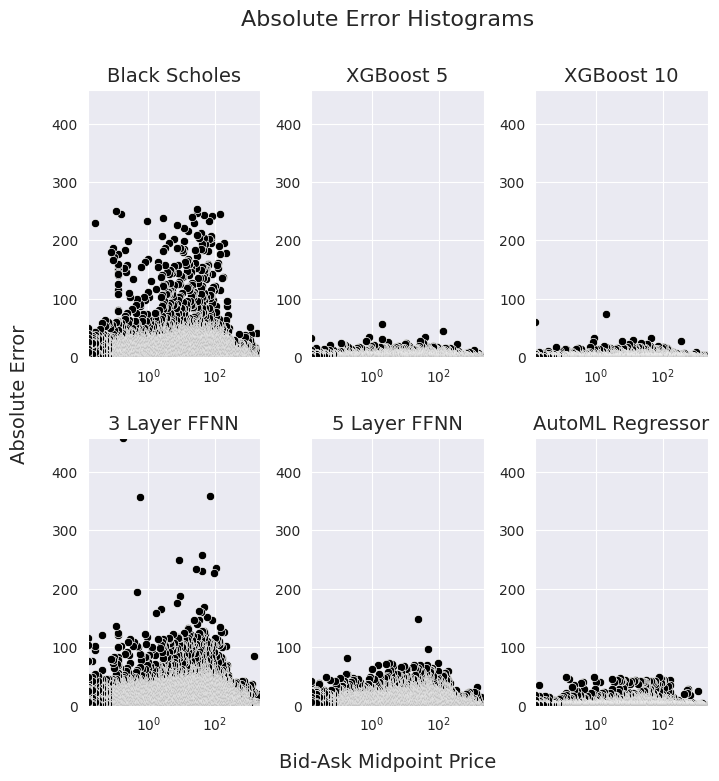

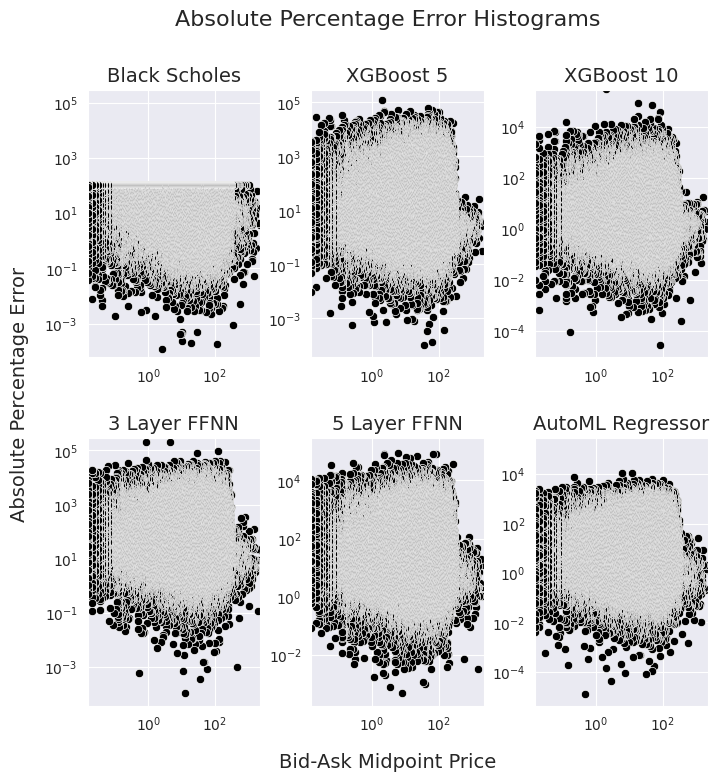

In [18]:
x_value = 'Bid-Ask Midpoint Price'
plot_absolute_error(df_test, x_value, x_log=True, y_log=False)
plot_absolute_percentage_error(df_test, x_value, x_log=True, y_log=True)

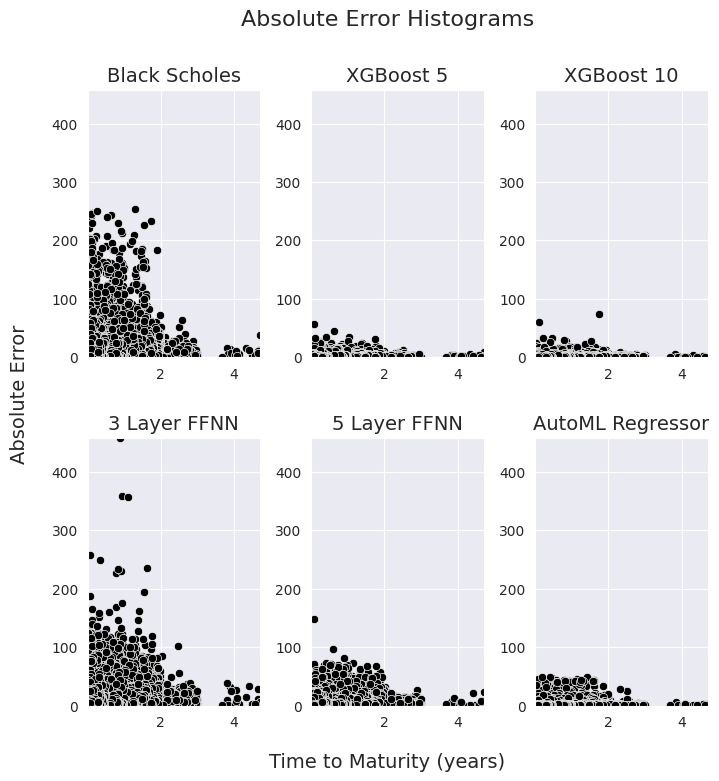

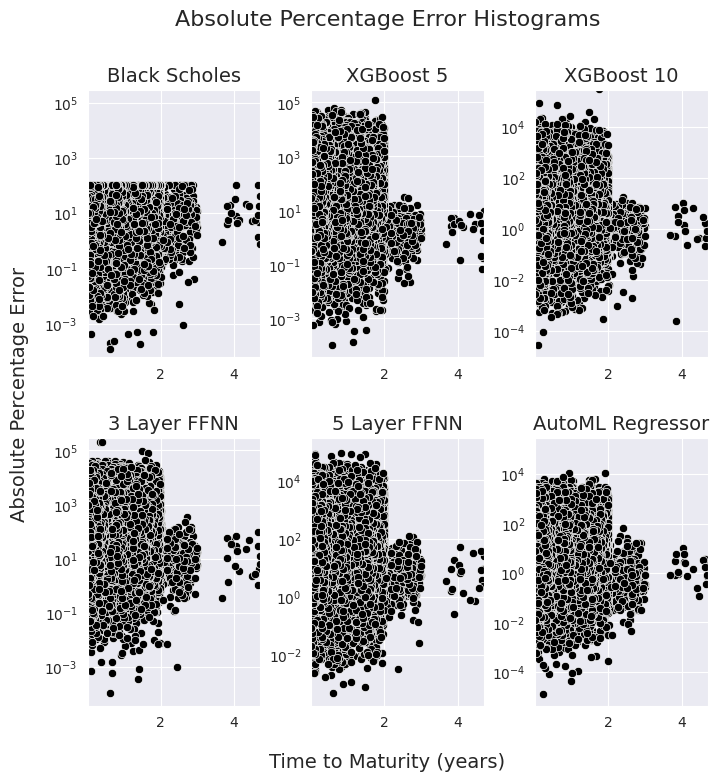

In [19]:
x_value = 'Time to Maturity (years)'
plot_absolute_error(df_test, x_value, x_log=False, y_log=False)
plot_absolute_percentage_error(df_test, x_value, x_log=False, y_log=True)

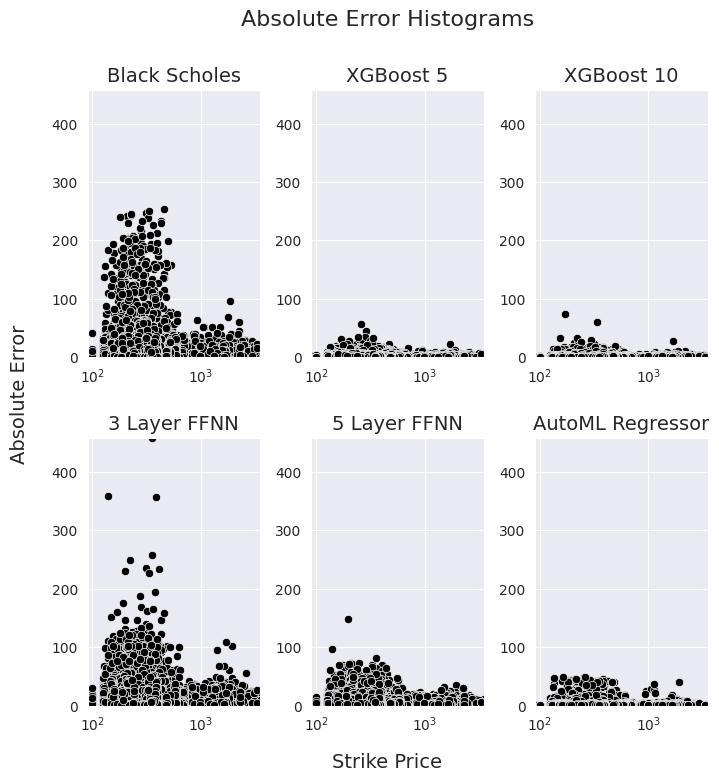

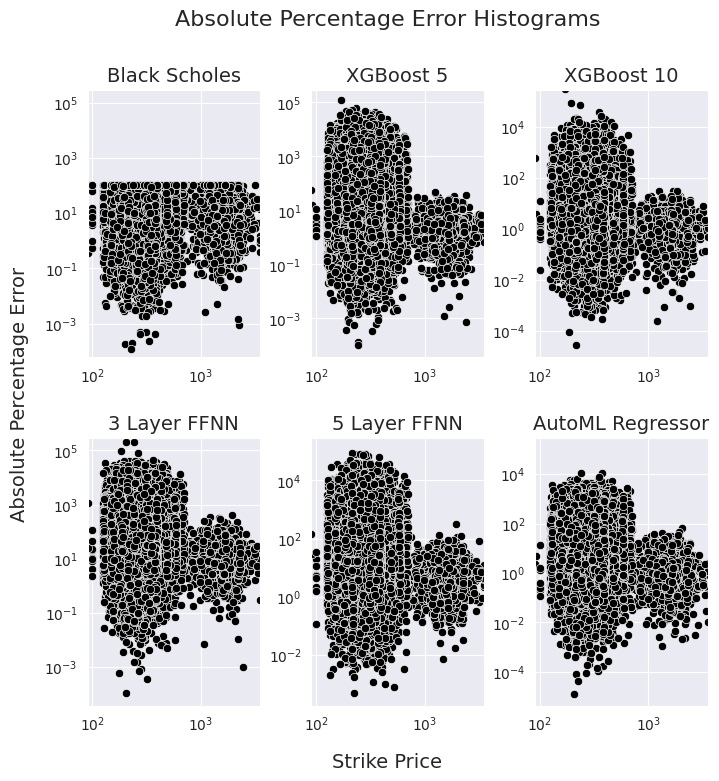

In [20]:
x_value = 'Strike Price'
plot_absolute_error(df_test, x_value, x_log=True, y_log=False)
plot_absolute_percentage_error(df_test, x_value, x_log=True, y_log=True)

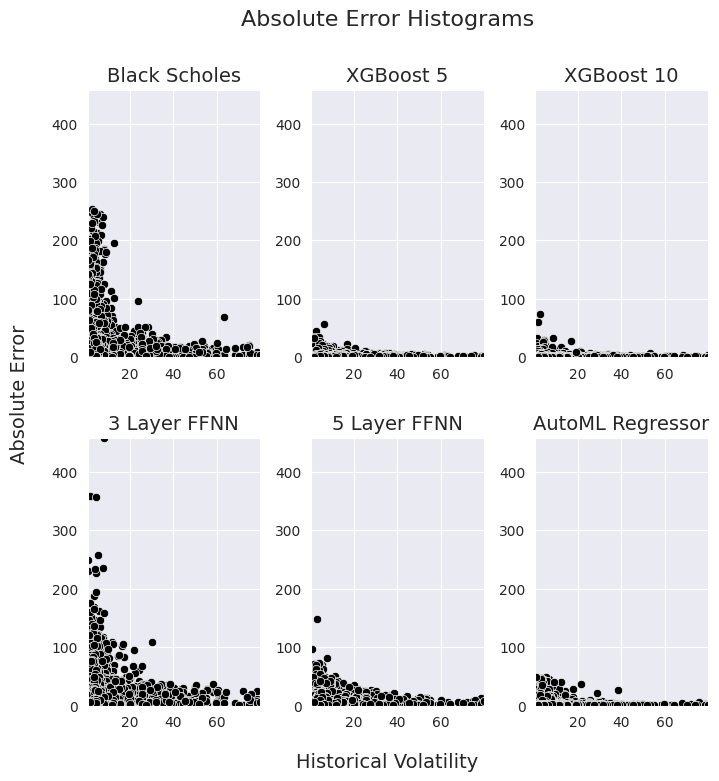

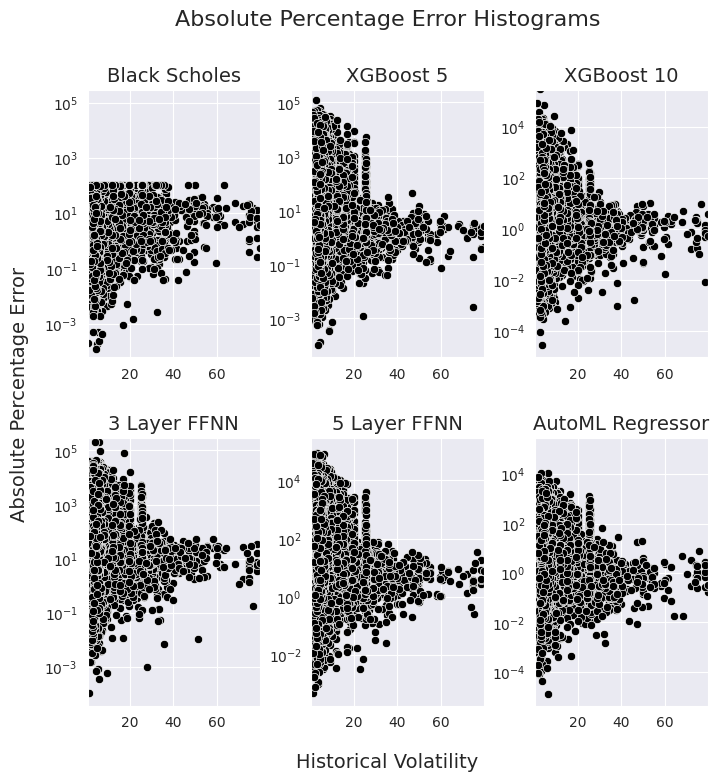

In [21]:
x_value = 'Historical Volatility'
plot_absolute_error(df_test, x_value, x_log=False, y_log=False)
plot_absolute_percentage_error(df_test, x_value, x_log=False, y_log=True)

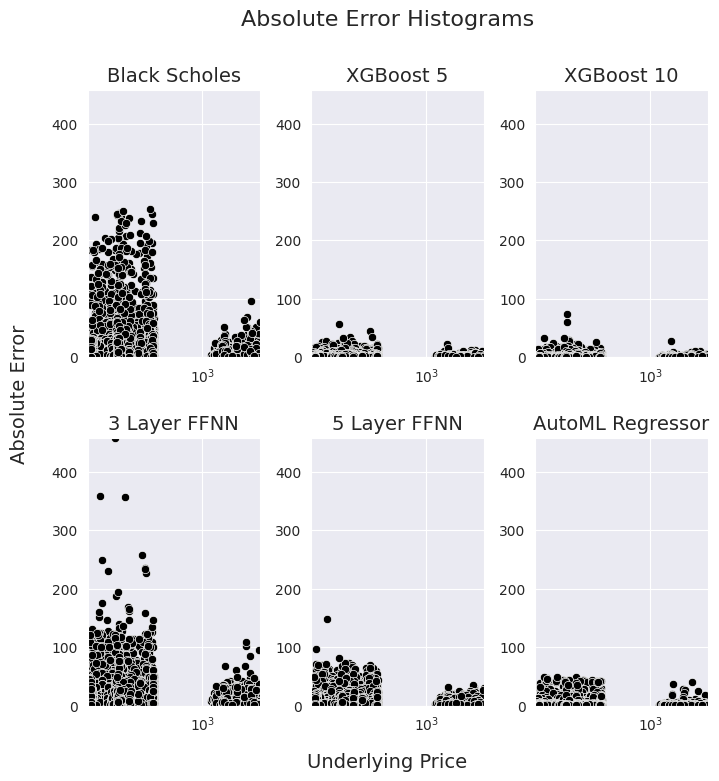

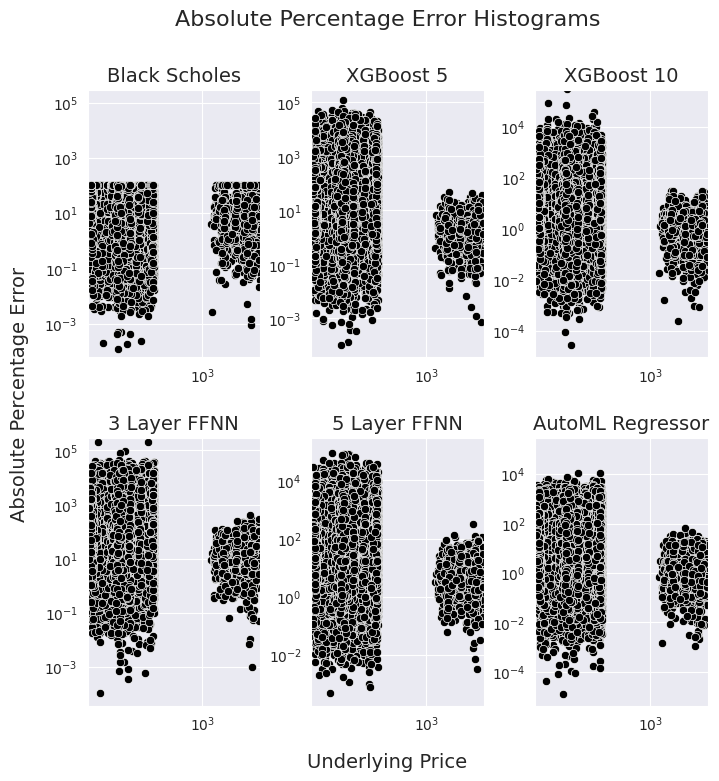

In [22]:
x_value = 'Underlying Price'
plot_absolute_error(df_test, x_value, x_log=True, y_log=False)
plot_absolute_percentage_error(df_test, x_value, x_log=True, y_log=True)

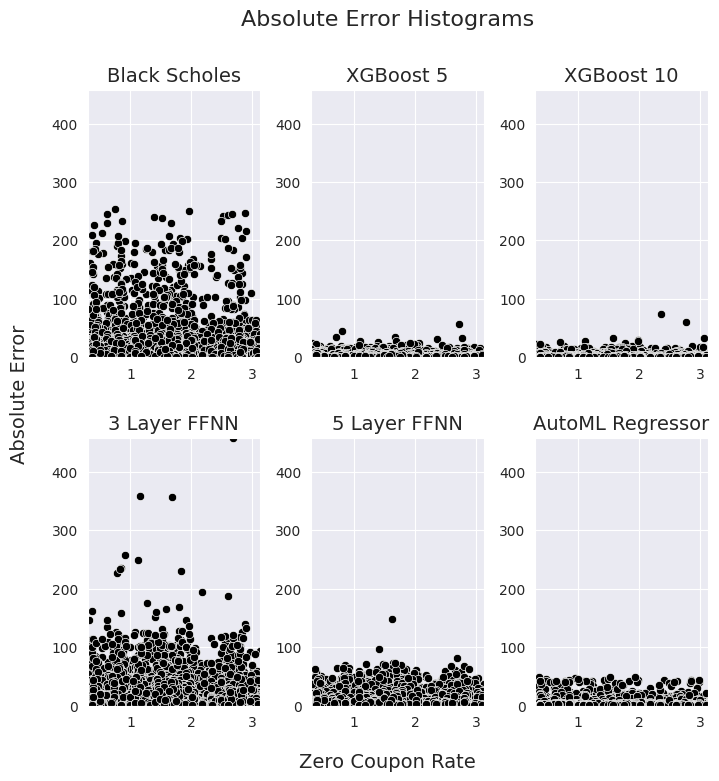

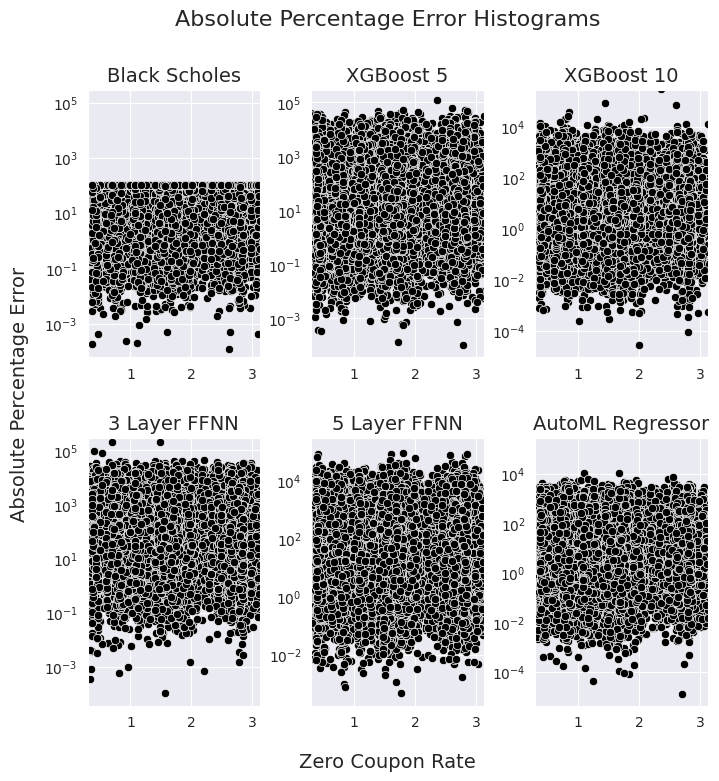

In [23]:
x_value = 'Zero Coupon Rate'
plot_absolute_error(df_test, x_value, x_log=False, y_log=False)
plot_absolute_percentage_error(df_test, x_value, x_log=False, y_log=True)

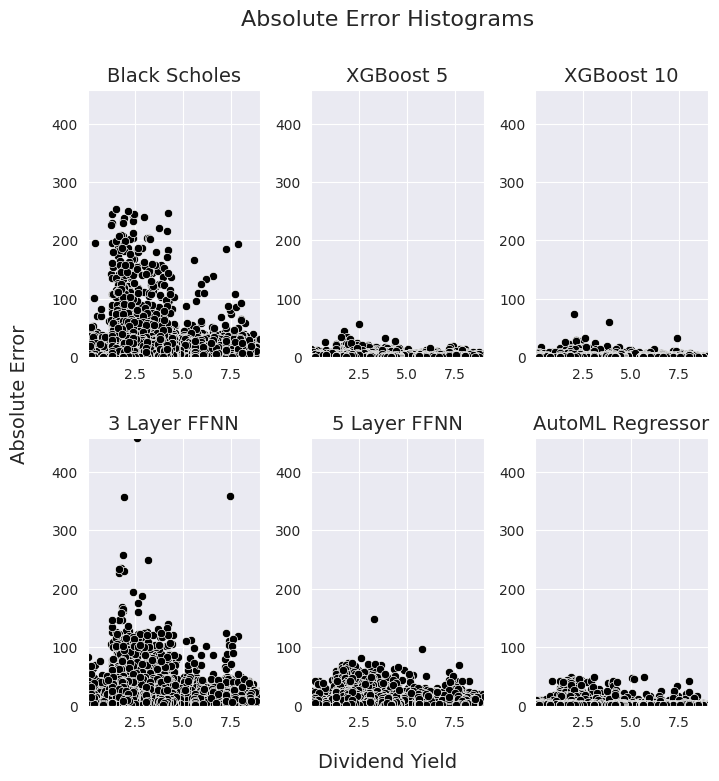

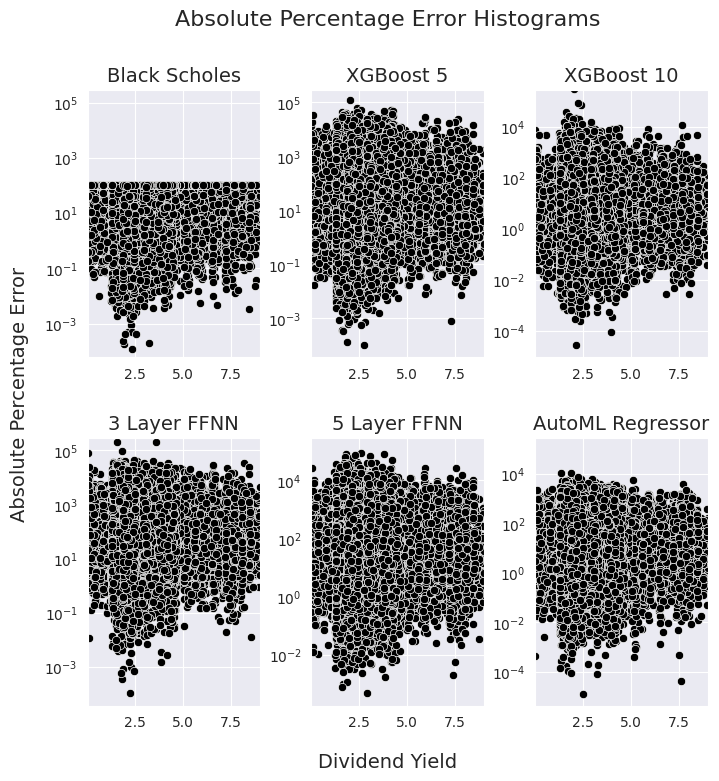

In [24]:
x_value = 'Dividend Yield'
plot_absolute_error(df_test, x_value, x_log=False, y_log=False)
plot_absolute_percentage_error(df_test, x_value, x_log=False, y_log=True)

In [25]:
# Create a Table with the Mean Absolute Error from Each Model
mean_absolute_error_table = df_test.groupby('Option Type').mean()[['Black-Scholes Absolute Error', 'XGBoost 5 Absolute Error',
                                                                   'XGBoost 10 Absolute Error', '3 Layer FFNN Absolute Error',
                                                                   '5 Layer FFNN Absolute Error', 'AutoML Regressor Absolute Error', ]
                                                                   ].round(2)
# Add a Totals Row
mean_absolute_error_table.loc['Total'] = mean_absolute_error_table.mean()

# Rename Columns with the Model Name + MAE
mean_absolute_error_table.columns = ['Black-Scholes MAE', 'XGBoost 5 MAE', 'XGBoost 10 MAE', '3 Layer FFNN MAE',
                                     '5 Layer FFNN MAE',  'AutoML Regressor MAE']

df = mean_absolute_error_table.transpose()
df.sort_values(by='Total', ascending=True)

Option Type           Call   Put  Total
XGBoost 10 MAE        0.80  0.82  0.810
AutoML Regressor MAE  1.03  1.02  1.025
XGBoost 5 MAE         1.63  1.64  1.635
5 Layer FFNN MAE      4.63  4.65  4.640
Black-Scholes MAE     7.99  8.03  8.010
3 Layer FFNN MAE      8.83  8.79  8.810

In [26]:
# Create a Table with the Mean Absolute Percentage Error from Each Model
mean_absolute_percentage_error_table = df_test.groupby('Option Type').mean()[['Black-Scholes Absolute Percentage Error', 'XGBoost 5 Absolute Percentage Error',
                                                                              'XGBoost 10 Absolute Percentage Error', '3 Layer FFNN Absolute Percentage Error',
                                                                              '5 Layer FFNN Absolute Percentage Error', 'AutoML Regressor Absolute Percentage Error',]
                                                                              ].round(2)

# Add a Totals Row
mean_absolute_percentage_error_table.loc['Total'] = mean_absolute_percentage_error_table.mean()

# Rename Columns with the Model Name + MAPE
mean_absolute_percentage_error_table.columns = ['Black-Scholes MAPE', 'XGBoost 5 MAPE', 'XGBoost 10 MAPE', '3 Layer FFNN MAPE',
                                                '4 Layer FFNN MAPE', '5 Layer FFNN MAPE']

df = mean_absolute_percentage_error_table.transpose()
df.sort_values(by='Total', ascending=True)

Option Type           Call     Put    Total
XGBoost 10 MAPE      42.70   41.71   42.205
5 Layer FFNN MAPE    43.24   42.19   42.715
Black-Scholes MAPE   63.93   63.82   63.875
XGBoost 5 MAPE      192.32  181.26  186.790
4 Layer FFNN MAPE   250.87  236.33  243.600
3 Layer FFNN MAPE   330.43  316.52  323.475

## Analysis of Results for Options with Bid-Ask Midpoint Prices above 100 and below 1000

In [27]:
# Filter Out Values where 'Midpoint' is below 100 and above 1000
df_test = df_test[(df_test['Bid-Ask Midpoint Price'] > 100) & (df_test['Bid-Ask Midpoint Price'] < 1000)]

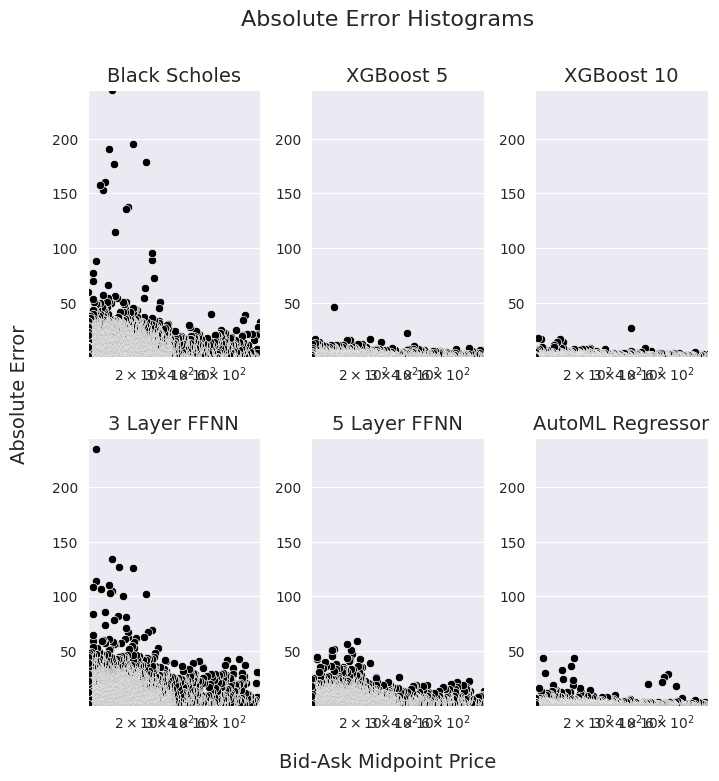

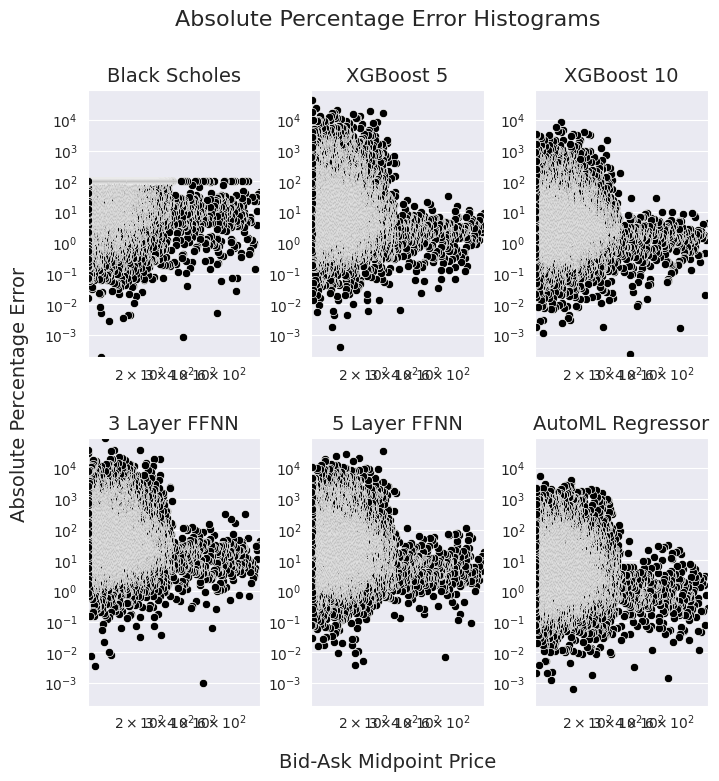

In [28]:
x_value = 'Bid-Ask Midpoint Price'
plot_absolute_error(df_test, x_value, x_log=True, y_log=False)
plot_absolute_percentage_error(df_test, x_value, x_log=True, y_log=True)

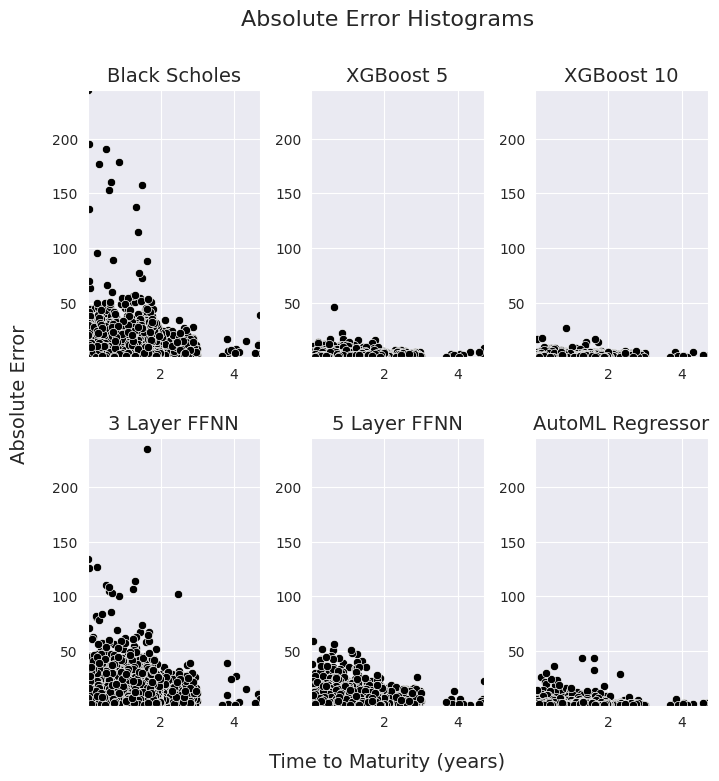

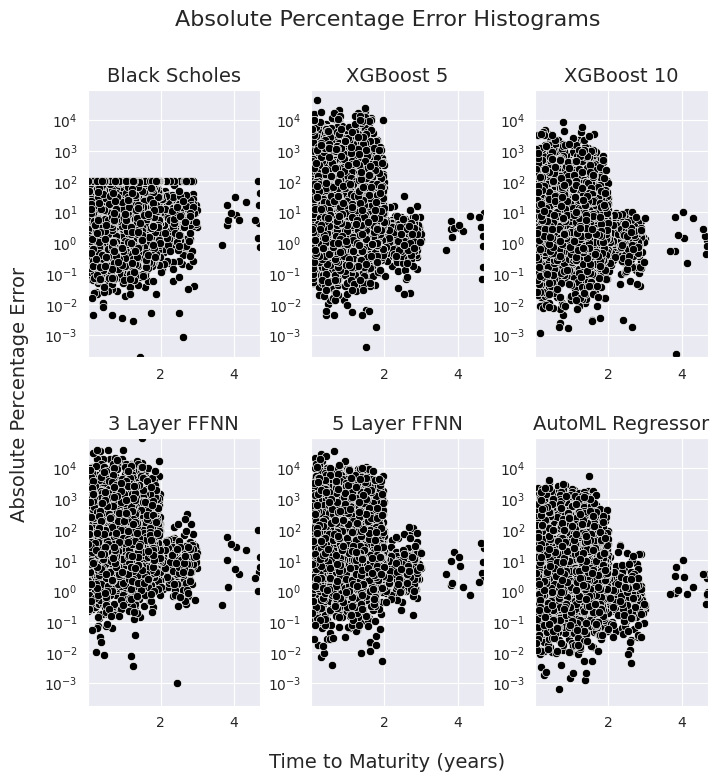

In [29]:
x_value = 'Time to Maturity (years)'
plot_absolute_error(df_test, x_value, x_log=False, y_log=False)
plot_absolute_percentage_error(df_test, x_value, x_log=False, y_log=True)

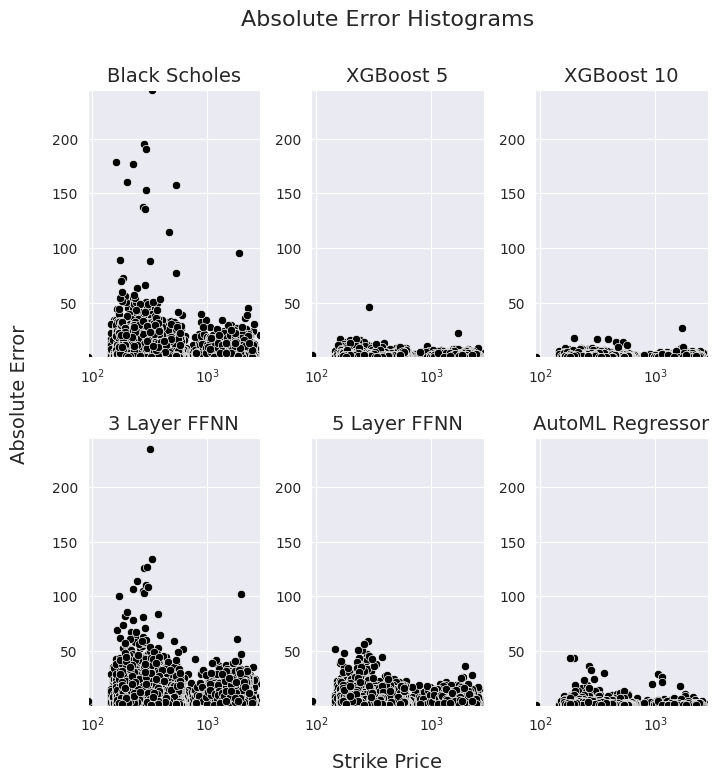

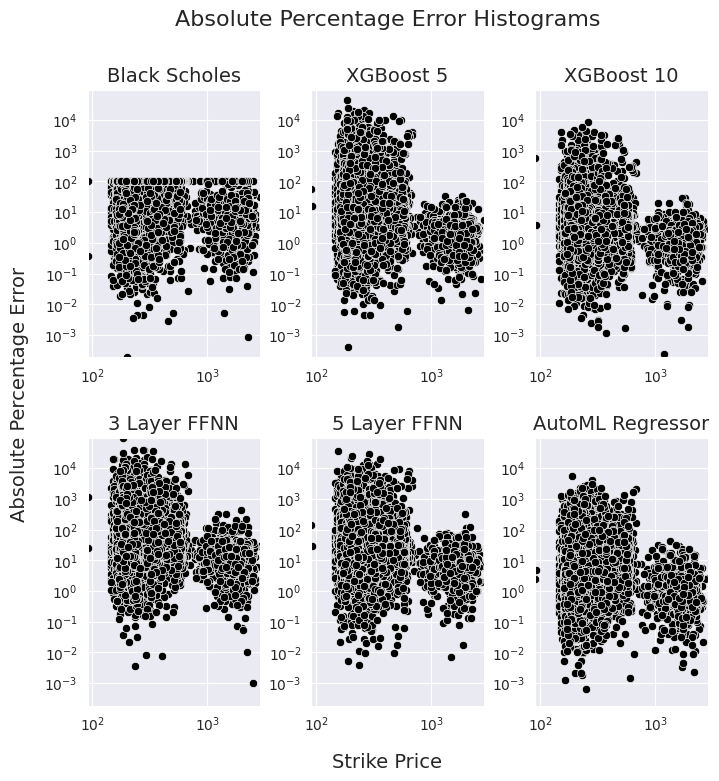

In [30]:
x_value = 'Strike Price'
plot_absolute_error(df_test, x_value, x_log=True, y_log=False)
plot_absolute_percentage_error(df_test, x_value, x_log=True, y_log=True)

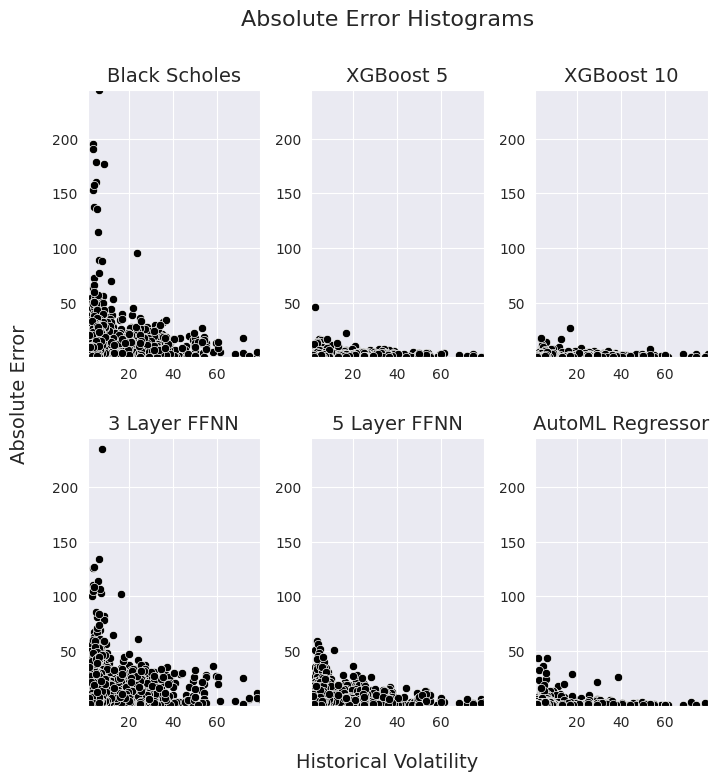

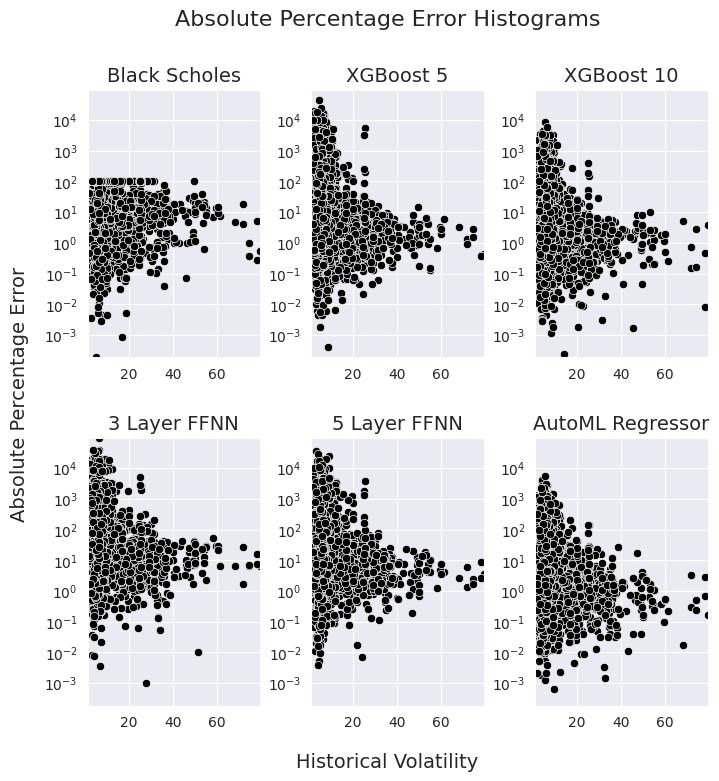

In [31]:
x_value = 'Historical Volatility'
plot_absolute_error(df_test, x_value, x_log=False, y_log=False)
plot_absolute_percentage_error(df_test, x_value, x_log=False, y_log=True)

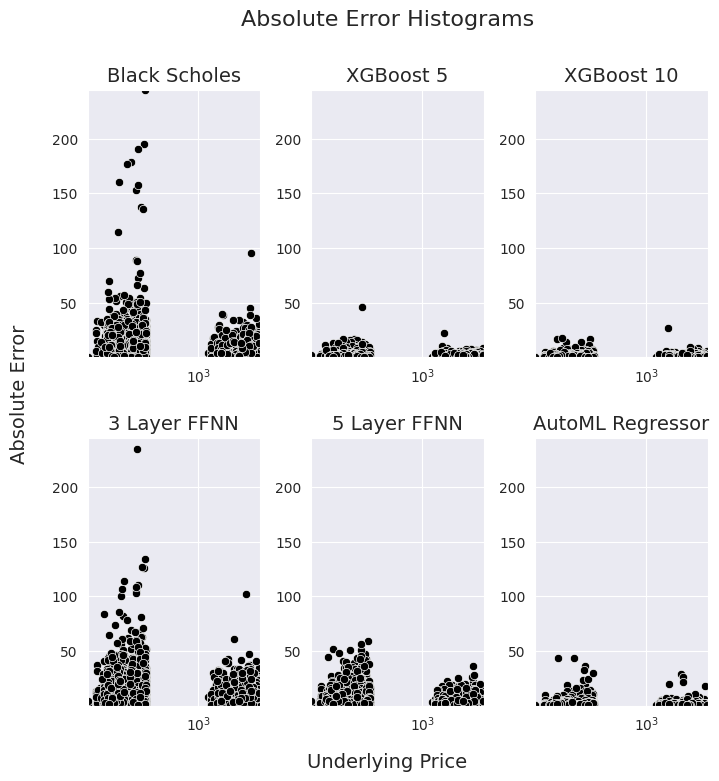

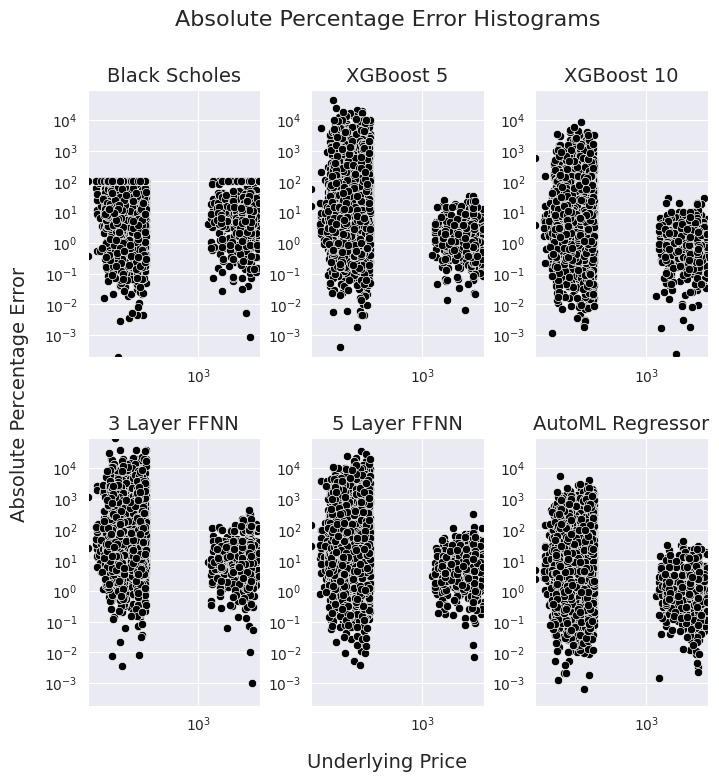

In [32]:
x_value = 'Underlying Price'
plot_absolute_error(df_test, x_value, x_log=True, y_log=False)
plot_absolute_percentage_error(df_test, x_value, x_log=True, y_log=True)

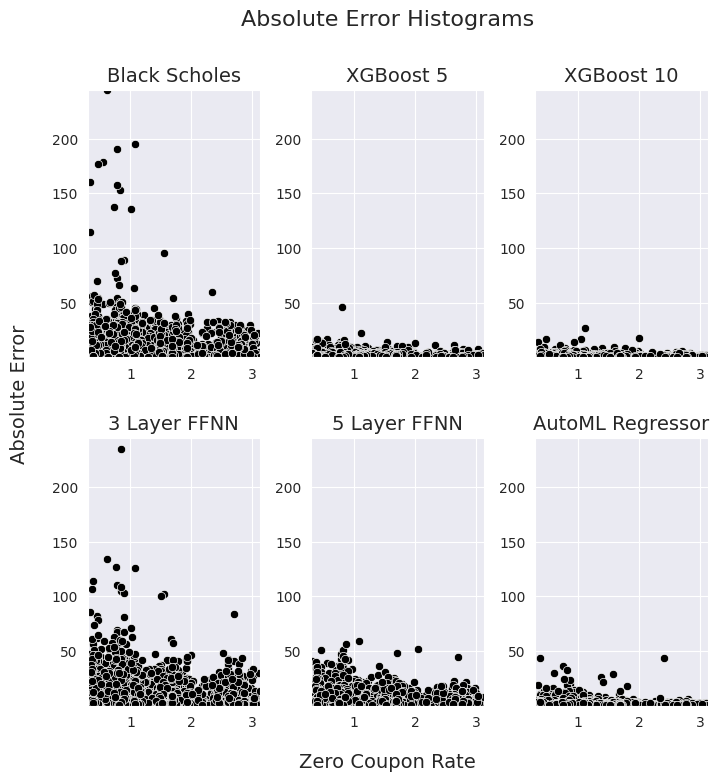

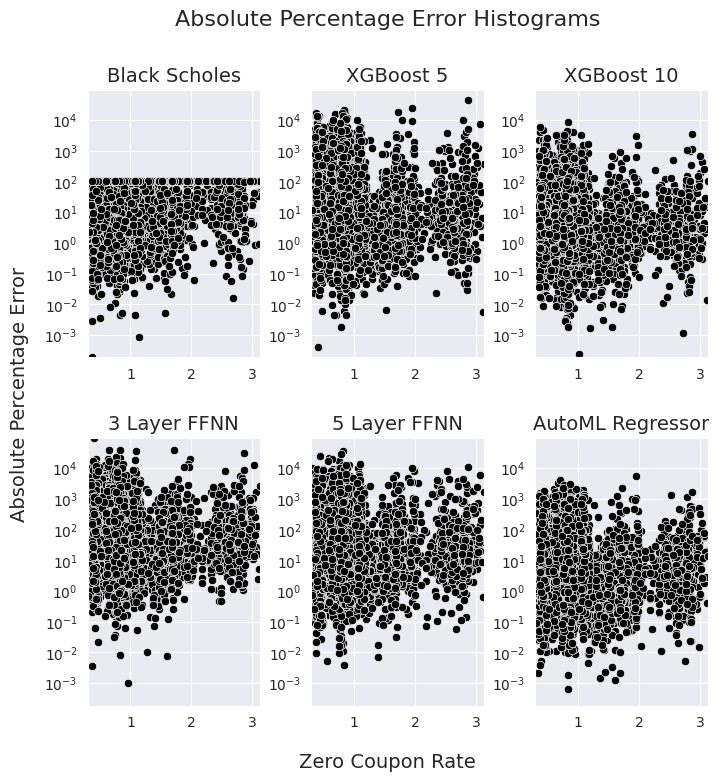

In [33]:
x_value = 'Zero Coupon Rate'
plot_absolute_error(df_test, x_value, x_log=False, y_log=False)
plot_absolute_percentage_error(df_test, x_value, x_log=False, y_log=True)

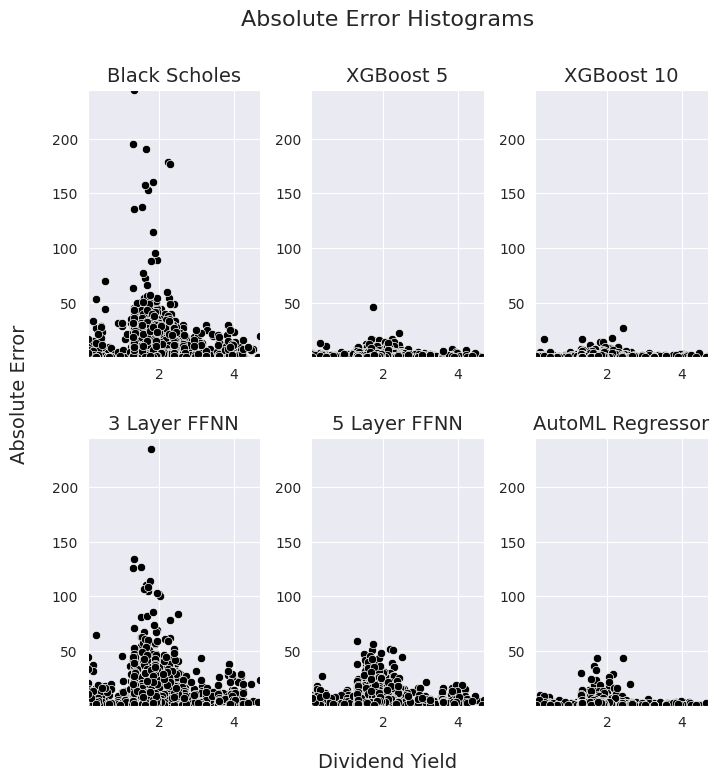

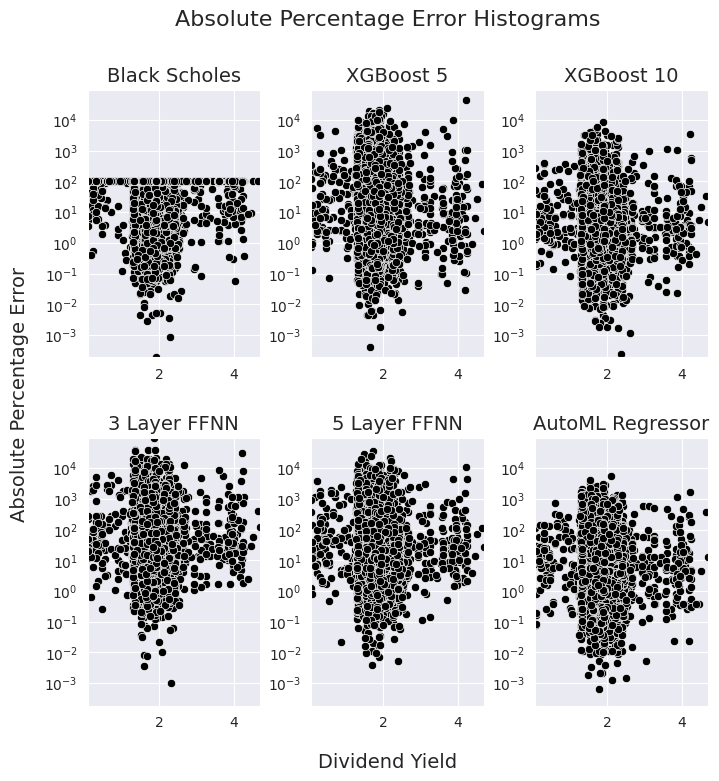

In [34]:
x_value = 'Dividend Yield'
plot_absolute_error(df_test, x_value, x_log=False, y_log=False)
plot_absolute_percentage_error(df_test, x_value, x_log=False, y_log=True)

In [35]:
# Create a Table with the Mean Absolute Error from Each Model
mean_absolute_error_table = df_test.groupby('Option Type').mean()[['Black-Scholes Absolute Error', 'XGBoost 5 Absolute Error',
                                                                   'XGBoost 10 Absolute Error', '3 Layer FFNN Absolute Error',
                                                                   '5 Layer FFNN Absolute Error', 'AutoML Regressor Absolute Error' ]
                                                                   ].round(2)
# Add a Totals Row
mean_absolute_error_table.loc['Total'] = mean_absolute_error_table.mean()

# Rename Columns with the Model Name + MAE
mean_absolute_error_table.columns = ['Black-Scholes MAE', 'XGBoost 5 MAE', 'XGBoost 10 MAE', '3 Layer FFNN MAE', 'AutoML Regressor',
                                     '5 Layer FFNN MAE']

df = mean_absolute_error_table.transpose()
df.sort_values(by='Total', ascending=True)

Option Type        Call   Put  Total
XGBoost 10 MAE     0.81  1.05  0.930
5 Layer FFNN MAE   1.04  1.08  1.060
XGBoost 5 MAE      1.64  1.71  1.675
AutoML Regressor   4.61  4.75  4.680
Black-Scholes MAE  7.88  8.23  8.055
3 Layer FFNN MAE   8.99  9.83  9.410

In [36]:
# Create a Table with the Mean Absolute Percentage Error from Each Model
mean_absolute_percentage_error_table = df_test.groupby('Option Type').mean()[['Black-Scholes Absolute Percentage Error', 'XGBoost 5 Absolute Percentage Error',
                                                                              'XGBoost 10 Absolute Percentage Error', '3 Layer FFNN Absolute Percentage Error',
                                                                              '5 Layer FFNN Absolute Percentage Error', 'AutoML Regressor Absolute Percentage Error']
                                                                              ].round(2)

# Add a Totals Row
mean_absolute_percentage_error_table.loc['Total'] = mean_absolute_percentage_error_table.mean()

# Rename Columns with the Model Name + MAPE
mean_absolute_percentage_error_table.columns = ['Black-Scholes MAPE', 'XGBoost 5 MAPE', 'XGBoost 10 MAPE', '3 Layer FFNN MAPE',
                                                 '5 Layer FFNN MAPE', 'AutoML Regressor MAPE',]

df = mean_absolute_percentage_error_table.transpose()
df.sort_values(by='Total', ascending=True)

Option Type              Call     Put    Total
XGBoost 10 MAPE         34.90   29.50   32.200
AutoML Regressor MAPE   43.06   31.56   37.310
Black-Scholes MAPE      61.29   48.47   54.880
XGBoost 5 MAPE         179.93  133.45  156.690
5 Layer FFNN MAPE      236.02  167.52  201.770
3 Layer FFNN MAPE      348.58  234.07  291.325